<a href="https://colab.research.google.com/github/onesummer123/c2s4_BDAO_Project/blob/main/Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Authenticate and access Google Cloud services
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import storage
from google.cloud import bigquery


# First make connection to BigQuery
project_id = "c2s4-project"
dataset_name = "restaurant_dataset_1"
table_name = "restaurant_tips"

bigquery_client = bigquery.Client(project=project_id)


# Query all data from the table
query = f"""
    SELECT *
    FROM `{project_id}.{dataset_name}.{table_name}`
"""

query_job = bigquery_client.query(query)
results = query_job.result()

tips_df = query_job.to_dataframe()
tips_df.head()

,user_id,business_id,text,date,compliment_count
0,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10+00:00,0
1,DWryovIM4VF2vim4p6WYaw,QoezRbYQncpRqyrLH6Iqjg,Turkey and roast beef,2012-10-11 13:04:02+00:00,0
2,DWryovIM4VF2vim4p6WYaw,QoezRbYQncpRqyrLH6Iqjg,Coffee and baby bread,2012-10-24 12:37:05+00:00,0
3,boRCdL8ez95KwzWe69VoUg,QoezRbYQncpRqyrLH6Iqjg,Such a great place to come and get a Cuban san...,2016-10-02 16:53:40+00:00,0
4,DWryovIM4VF2vim4p6WYaw,QoezRbYQncpRqyrLH6Iqjg,My last time. Continental and a Cuban,2012-11-09 18:51:34+00:00,0


In [ ]:
import pandas as pd


target_column = 'text'
tips_df = tips_df[['business_id','text']]
tips_df = tips_df.drop_duplicates().reset_index(drop=True)
tips_df = tips_df.dropna(subset=[target_column])

tips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647024 entries, 0 to 647023
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  647024 non-null  object
 1   text         647024 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [ ]:
!pip install contractions

import re
import string
import contractions
import nltk
import gensim
from gensim.utils import simple_preprocess
import spacy

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


df = tips_df
target_column = 'text'

# remove contraction
df[target_column] = df[target_column].map(lambda x: contractions.fix(x))

# convert the relevant column to lowercase
df[target_column] = df[target_column].str.lower()

# Remove overspace
df[target_column] = df[target_column].map(lambda x: re.sub('\s{2,}', " ", x))

# Remove non-word characters, so numbers and ___ etc
df[target_column] = df[target_column].str.replace("[^A-Za-z]", " ", regex = True)

# Remove punctuation
df[target_column] = df[target_column].map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# create a list of the contents from the 'contents' column
words = df[target_column].tolist()

# tokenise the words
word_tokens = []
for content in words:
    word_tokens.append(word_tokenize(content))

# create bigram model
bigram = gensim.models.phrases.Phrases(word_tokens, min_count=3, threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram) # Faster way to get a sentence clubbed as a trigram/bigram

# NLTK Stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# add more stopwords
stop_words.extend(['good','great','food','excellent','well','go','awesome','get',
                   'amazing','nice','really','eat','ever','some', 'bad', 'lot',
                   'always','much','terrible','still','definitely'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define functions for stopwords, bigrams and lemmatisation
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove stopwords
data_words_nostops = remove_stopwords(word_tokens)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatisation keeping only noun, adj, vb, adv
data_lemmatised = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# put the tokens back together as text to have our filtered contents

rejoin = []
for content in data_lemmatised: # Here we choose to use stemming instead of lemmatisation
    x = " ".join(content) # join the text back together
    rejoin.append(x)

# add the reformed text to the data frame
df['cleaned_review'] = rejoin

In [ ]:
# vectorise the data into word counts

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

max_words = 1000 #how many words taking account for topic modeling
vectorizer = CountVectorizer(max_features=max_words)
vec = vectorizer.fit_transform(df['cleaned_review'])

k = 6 #this is the number of the topic. you can decide the number

lda = LDA(n_components=k, max_iter=5, learning_method='online', random_state = 10)
lda.fit(vec)

LatentDirichletAllocation(learning_method='online', max_iter=5, n_components=6,
                          random_state=10)

Topic#  1
place,try,close,love,breakfast,good,burger,make,meal,little,sauce,delicious,fresh,roll,business,price,option,quality,decent,sandwich,absolutely,thing,brunch,soup,highly_recommend,big,far,spicy,dish,portion,fish,choice,cheesesteak,expensive,sushi,beef,reservation,egg,yum,bowl,drive_thru,different,cute,variety,value,view,card,size,world,least

Topic#  2
service,time,menu,price,chicken,salad,wing,special,hour,slow,go,pizza,long,use,see,drink,pretty,selection,bring,cheap,bad,make,horrible,rude,thank,sweet,deal,line,first_time,friend,bartender,music,huge,old,new,return,tip,appetizer,enough,money,pork,dinner,item,city,seem,point,add,happy_hour,seafood,regular

Topic#  3
order,friendly,place,staff,back,take,fast,people,coffee,favorite,never,check,quick,find,give,owner,pm,stop,experience,call,right,family,go,authentic,leave,wrong,first,minute,large,pay,pick,year,employee,dessert,tonight,know,chinese,customer,want,donut,die,average,vegan,kid,rice,outstanding,manager,put,star,incredibl

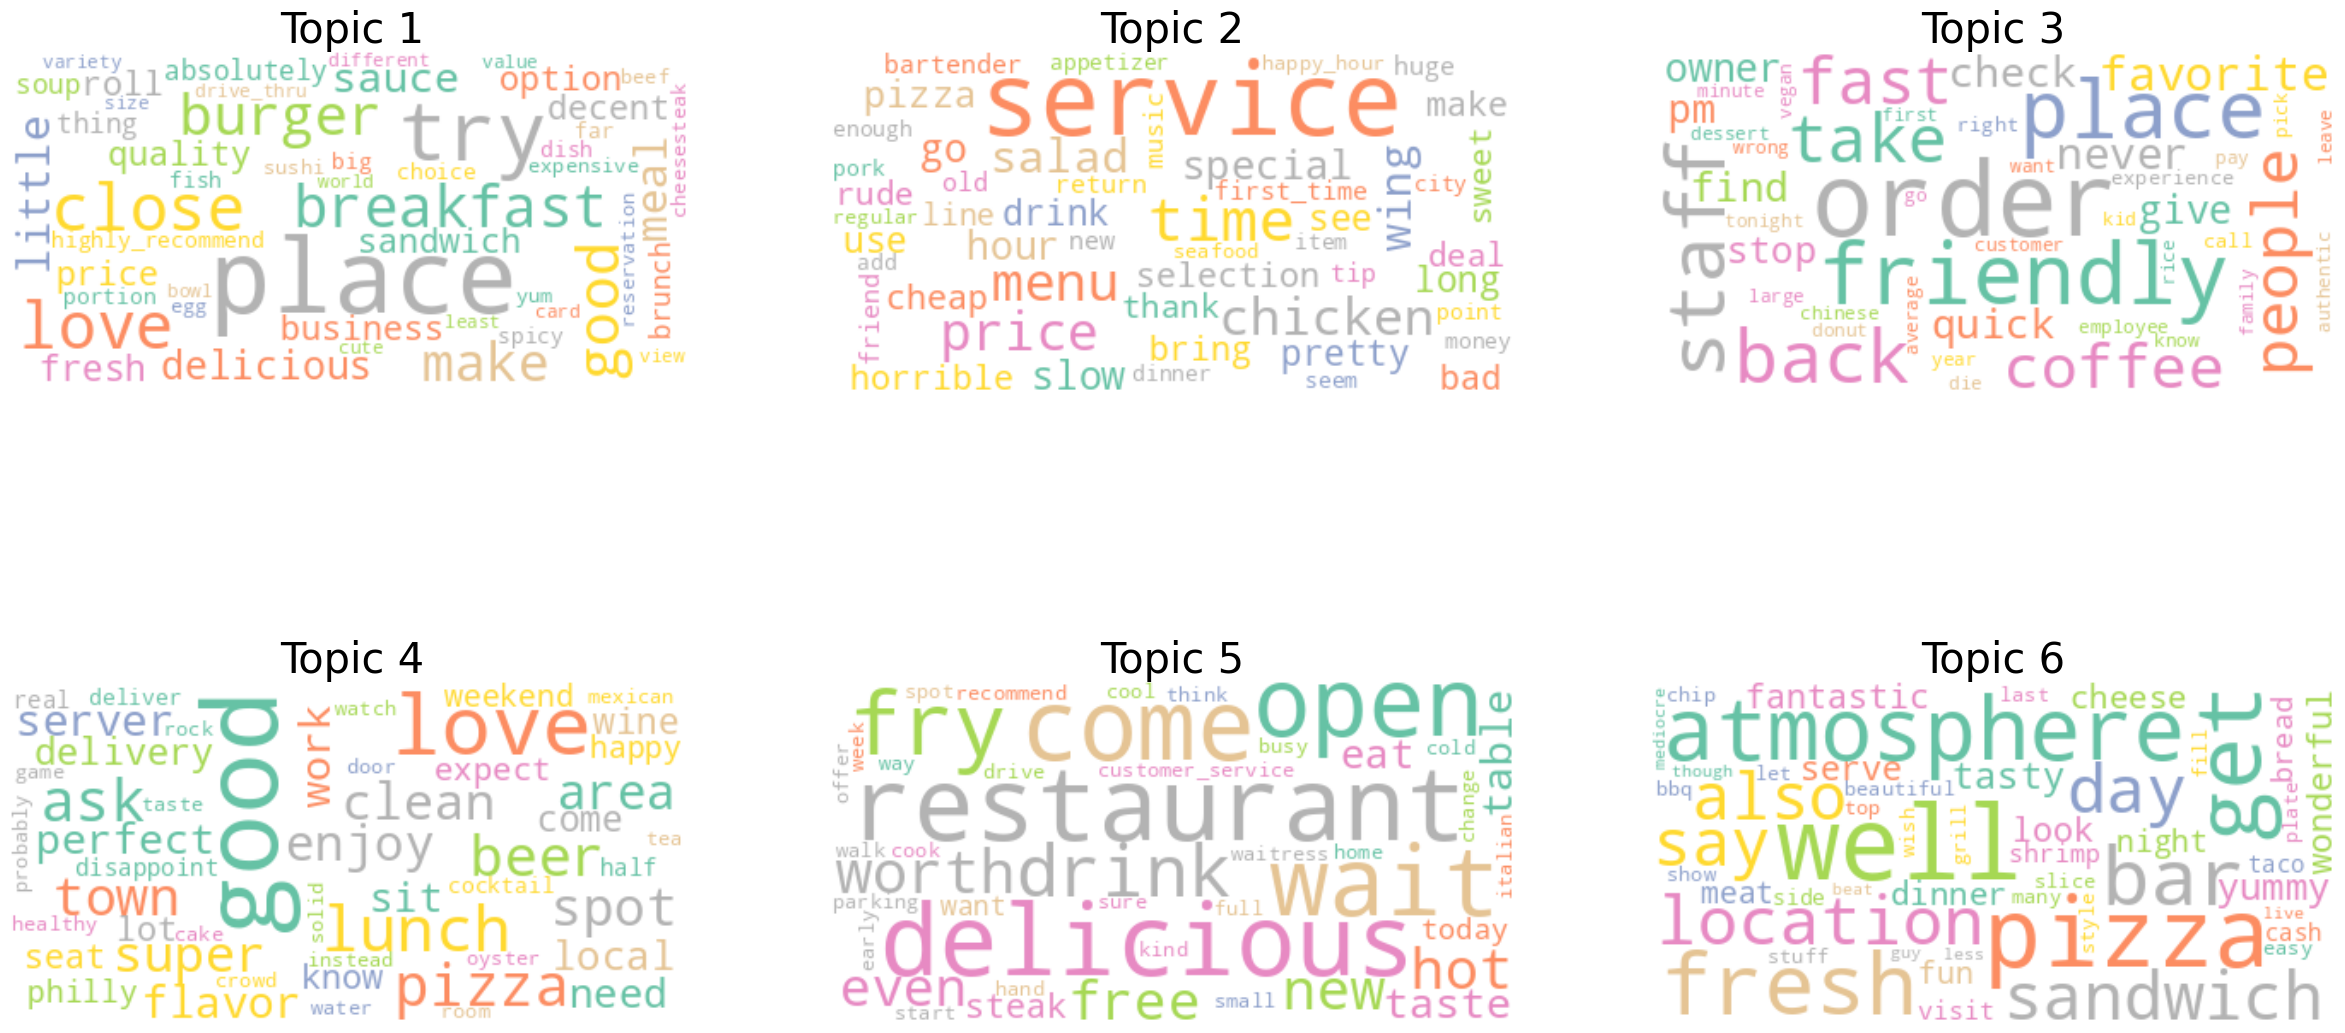

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import wordcloud

#declaring number of terms we need per topic
terms_count = 50

terms = vectorizer.get_feature_names_out()

wcloud = wordcloud.WordCloud(background_color="White",mask=None, max_words=100,\
                             max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
                             contour_width=3,contour_color='Black',colormap='Set2')

fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
axes = axes.flatten()

for idx,topic in enumerate(lda.components_):
    print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
    print(','.join( word for word in topic_words))
    print("")
    dict_word_frequency = {}

    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]

    ax = axes[idx]
    ax.set_title(f'Topic {idx +1}',fontdict={'fontsize': 30})
    wcloud.generate_from_frequencies(dict_word_frequency)
    ax.imshow(wcloud, interpolation='bilinear')
    ax.axis("off")

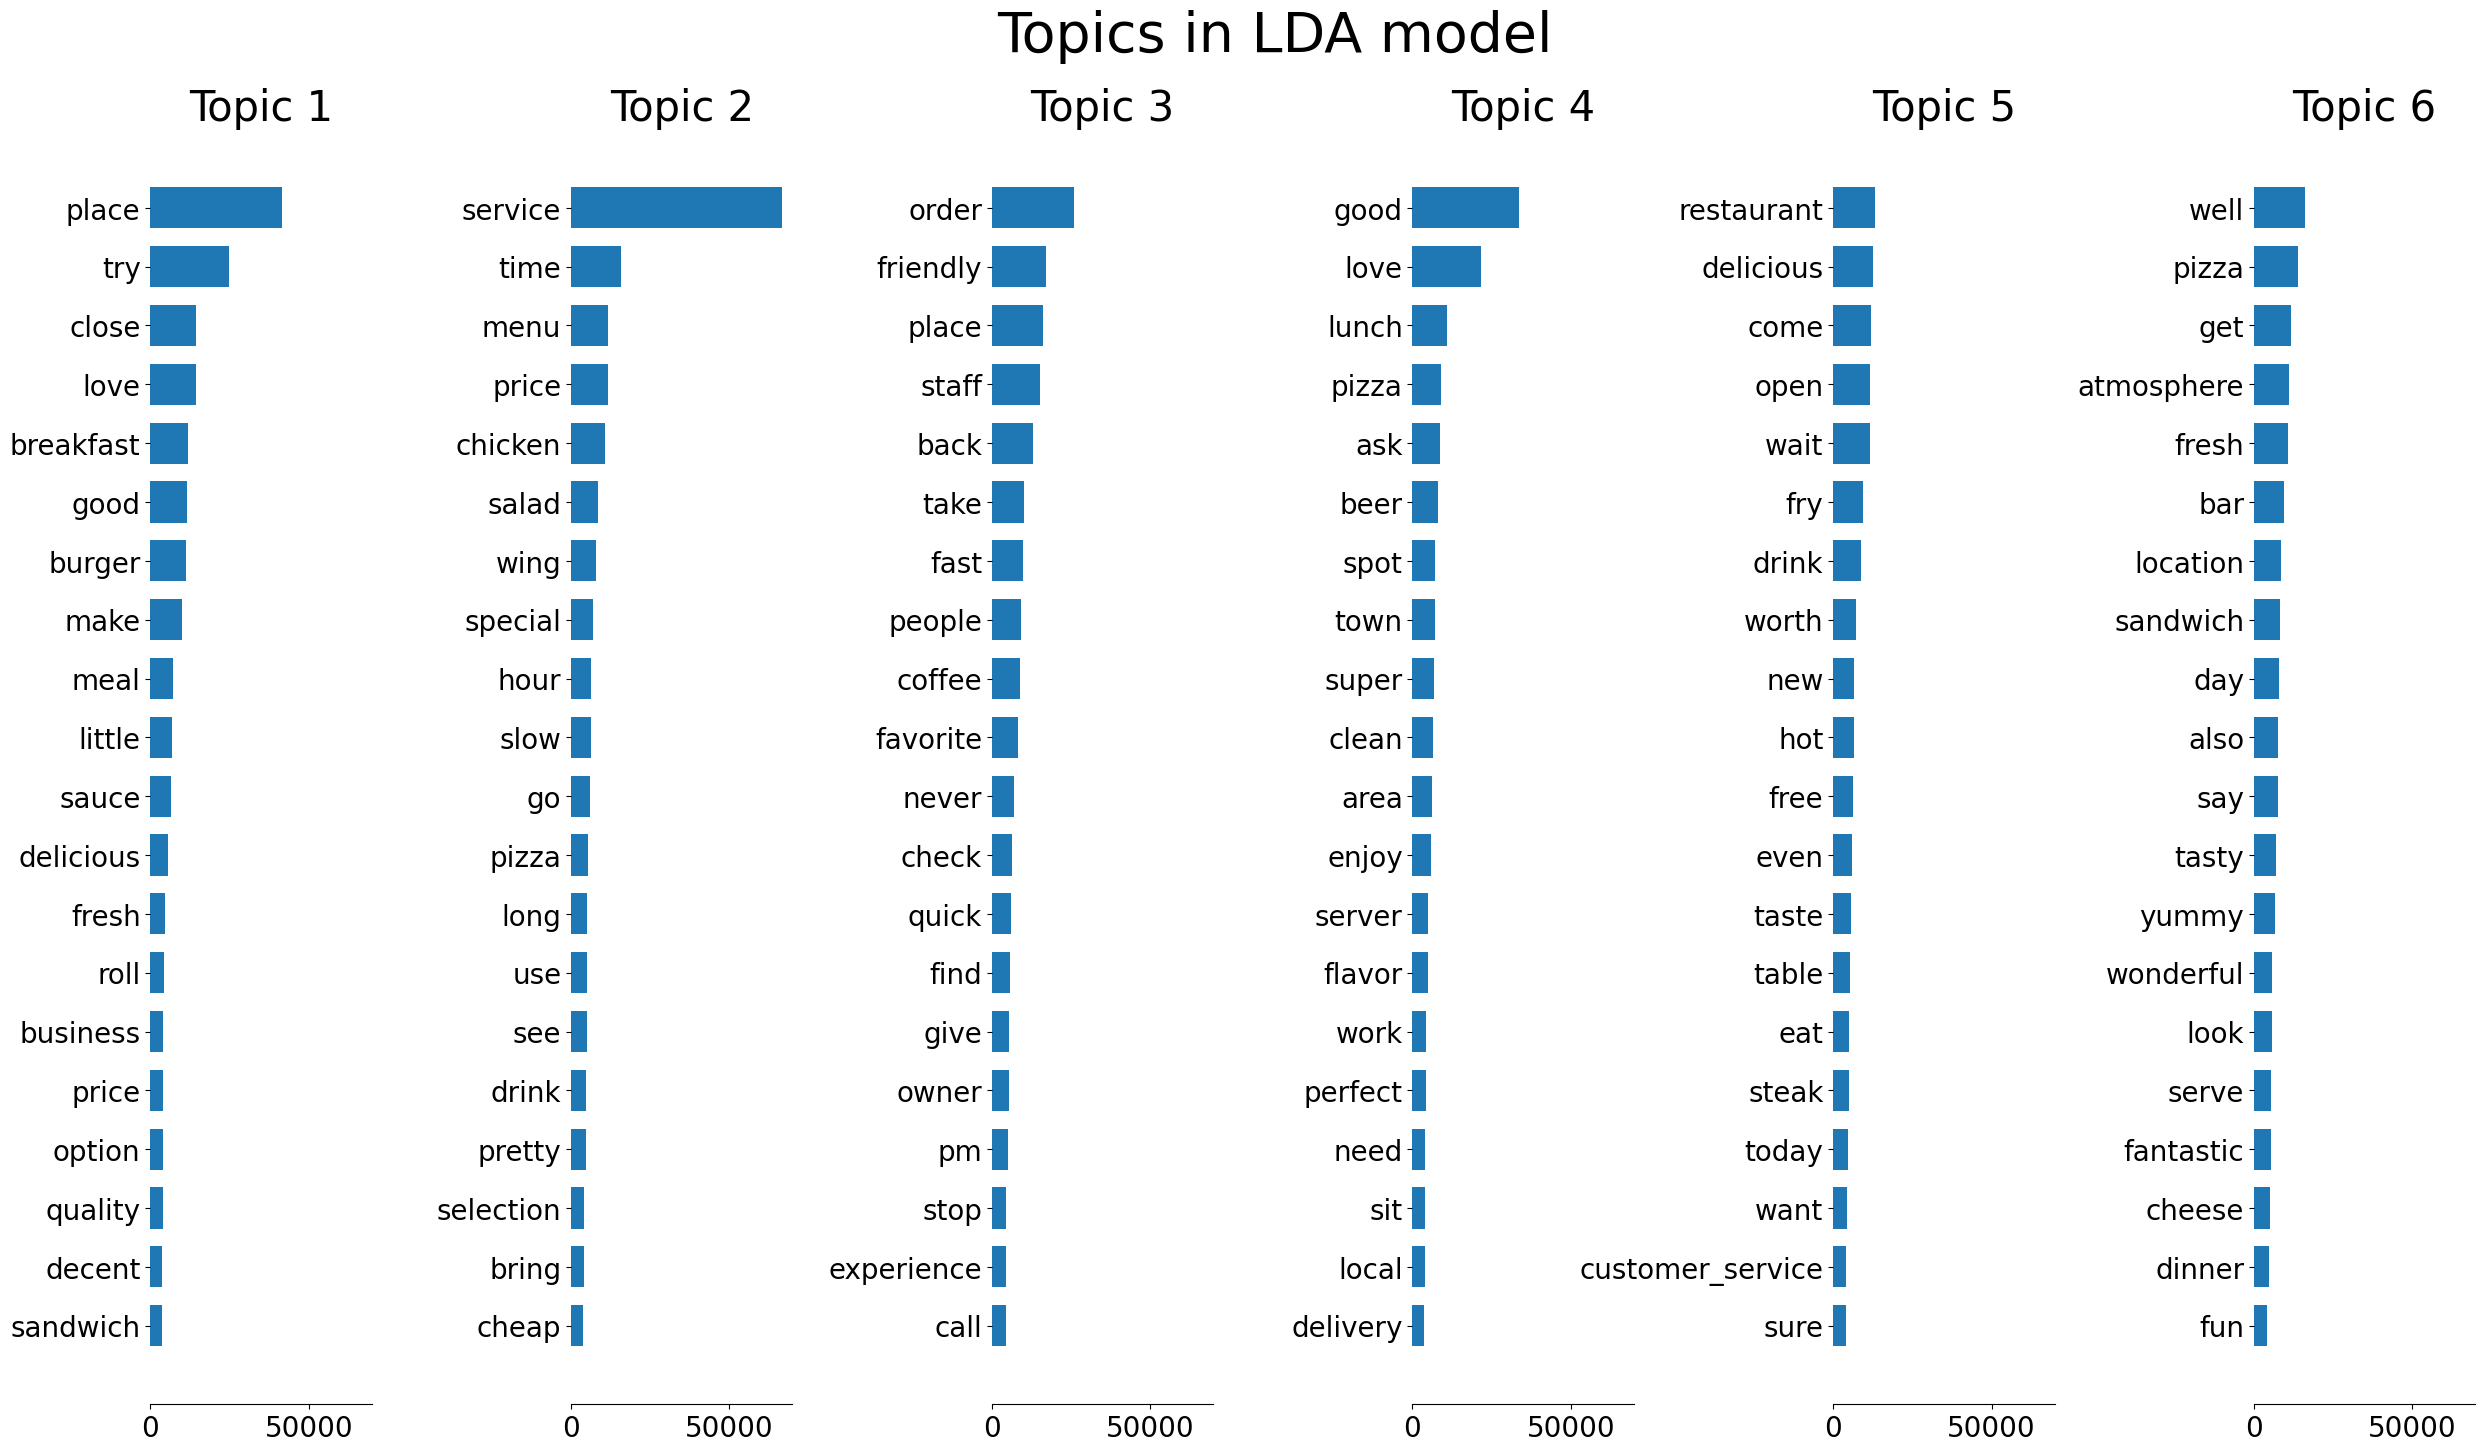

In [ ]:
# Visualise the result into bar charts in topic

%matplotlib inline
import matplotlib.pyplot as plt

# helper function to plot topics
# see Grisel et al.
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 6, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20  #how many words to be visualised in each topic

# get the list of words (feature names)
vec_feature_names = vectorizer.get_feature_names_out()

# print the top words per topic
plot_top_words(lda, vec_feature_names, n_top_words, 'Topics in LDA model')


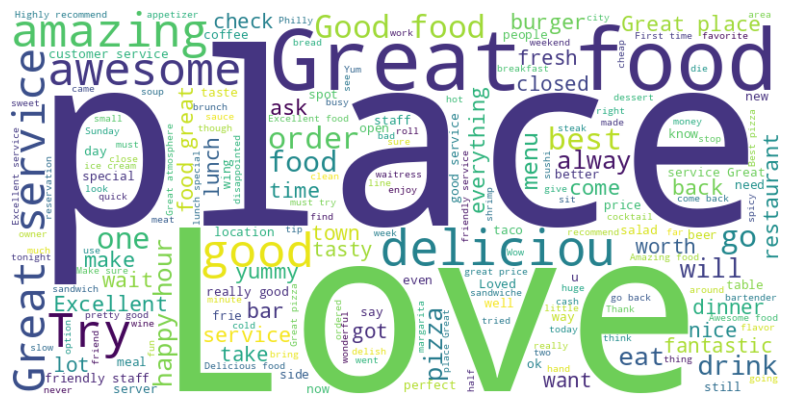

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt


# store texts in one string
text = ' '.join(df['text'].astype(str))

# generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

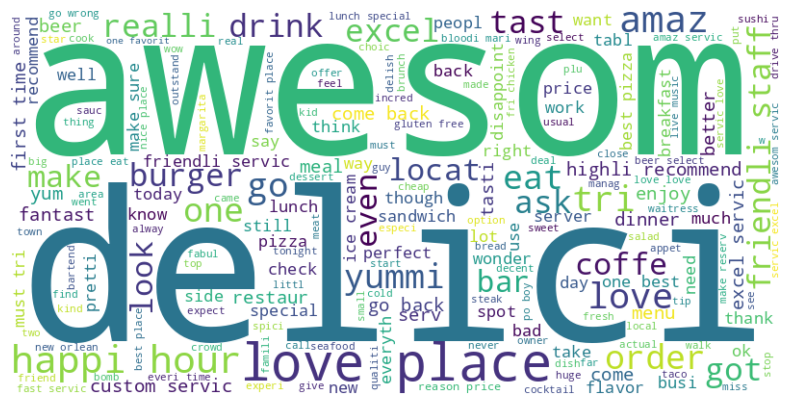

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt


word_string = ' '.join([item for sublist in stemmed for item in sublist])
wc = WordCloud(width=800, height=400, background_color='white').generate(word_string)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

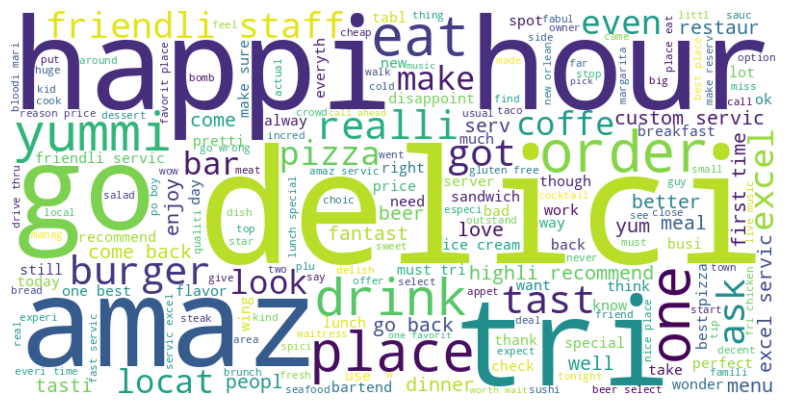

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt


word_string = ' '.join([item for sublist in stemmed for item in sublist])
wc = WordCloud(width=800, height=400, background_color='white').generate(word_string)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

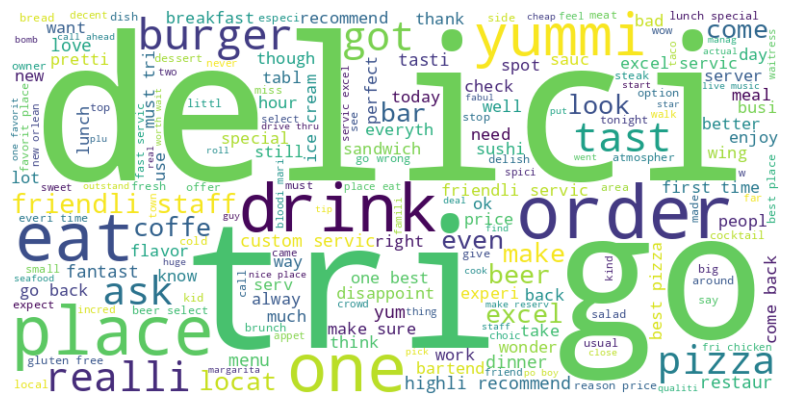

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt


word_string = ' '.join([item for sublist in stemmed for item in sublist])
wc = WordCloud(width=800, height=400, background_color='white').generate(word_string)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Before running the module, we need to download some packages and list of tags available in nltk
nltk.download('tagsets')
print(nltk.help.upenn_tagset())

nltk.download('averaged_perceptron_tagger')

In [ ]:
from textblob import TextBlob


# 定义情感分析函数
def analyze_sentiment(comment):
    analysis = TextBlob(comment)
    # 使用TextBlob库的sentiment属性获取评论的情感极性
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity == 0:
        return 'neutral'
    else:
        return 'negative'

# 对评论进行情感分析--3min
clean_tips_df['sentiment'] = clean_tips_df['text'].apply(analyze_sentiment)


<ipython-input-10-f5afcd89c162>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_tips_df['sentiment'] = clean_tips_df['text'].apply(analyze_sentiment)


In [ ]:
clean_tips_df.head()

,business_id,text,sentiment
0,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,positive
1,QoezRbYQncpRqyrLH6Iqjg,Turkey and roast beef,neutral
2,QoezRbYQncpRqyrLH6Iqjg,Coffee and baby bread,neutral
3,QoezRbYQncpRqyrLH6Iqjg,Such a great place to come and get a Cuban san...,positive
4,QoezRbYQncpRqyrLH6Iqjg,My last time. Continental and a Cuban,neutral


In [ ]:
clean_tips_df['sentiment'].value_counts()

sentiment
positive    430435
neutral     144071
negative     74627
Name: count, dtype: int64

In [ ]:
# 根据 "id" 列分组，并统计每个分组中 "sentiment" 列的值的数量
sentiment_counts_by_id = clean_tips_df.groupby('business_id')['sentiment'].value_counts()

# 重置索引并将其存储到一个新的 DataFrame 中
sentiment_counts_df = sentiment_counts_by_id.reset_index()

In [ ]:
sentiment_counts_df


,business_id,sentiment,count
0,---kPU91CF4Lq2-WlRu9Lw,positive,4
1,--0iUa4sNDFiZFrAdIWhZQ,positive,5
2,--0iUa4sNDFiZFrAdIWhZQ,neutral,1
3,--7PUidqRWpRSpXebiyxTg,positive,3
4,--8IbOsAAxjKRoYsBFL-PA,positive,3
...,...,...,...
101638,zznJox6-nmXlGYNWgTDwQQ,negative,4
101639,zznJox6-nmXlGYNWgTDwQQ,positive,1
101640,zznJox6-nmXlGYNWgTDwQQ,neutral,1
101641,zzu6_r3DxBJuXcjnOYVdTw,positive,2
